In [2]:
import pandas as pd
import numpy as np

dataPath18 = "data/atp_matches_2018.csv"
dataPath19 = "data/atp_matches_2019.csv"
dataPath20 = "data/atp_matches_2020.csv"
dataPathPlayers = "data/atp_players.csv"
dataPathRankings10s = "data/atp_rankings_10s.csv"
dataPathRankingsCurrent = "data/atp_rankings_current.csv"

data18 = pd.read_csv(dataPath18)
data19 = pd.read_csv(dataPath19)
data20 = pd.read_csv(dataPath20)
dataPlayers = pd.read_csv(dataPathPlayers, names = ['id', 'first_name', 'last_name', 'hand', 'date_of_birth', 'nationality'])
dataRankings10s = pd.read_csv(dataPathRankings10s)
dataRankingsCurrent = pd.read_csv(dataPathRankingsCurrent, names = ['ranking_date', 'rank', 'player', 'points'])
#print(data18)
#print(data19)
#print(data20)

print(data18.shape)
data18 = data18.drop_duplicates()
print(data18.shape)

print(data19.shape)
data19 = data19.drop_duplicates()
print(data19.shape)

print(data20.shape)
data20 = data20.drop_duplicates()
print(data20.shape)

dataMatchesTotal = pd.concat([data18, data19, data20])
dataRatingsTotal = pd.concat([dataRankings10s, dataRankingsCurrent])
print(dataRatingsTotal)
print(dataMatchesTotal.shape)

#Da li se imena iz kolona winner_id i loser_id mogu uzeti za id (da li ima vise igraca koji se isto zovu)?
data_check = dataMatchesTotal[['winner_id', 'winner_name']].groupby('winner_id').winner_name.nunique()
print(data_check[data_check > 1])
data_check = dataMatchesTotal[['loser_id', 'loser_name']].groupby('loser_id').loser_name.nunique()
print(data_check[data_check > 1])


(2889, 49)
(2889, 49)
(2781, 49)
(2781, 49)
(1447, 49)
(1447, 49)
       ranking_date  rank  player   points
0          20100104     1  103819  10550.0
1          20100104     2  104745   9205.0
2          20100104     3  104925   8310.0
3          20100104     4  104918   7030.0
4          20100104     5  105223   6785.0
...             ...   ...     ...      ...
51152      20201221   896  209857     15.0
51153      20201221   897  103565     15.0
51154      20201221   898  125800     15.0
51155      20201221   899  132575     15.0
51156      20201221   900  126630     15.0

[967453 rows x 4 columns]
(7117, 49)
Series([], Name: winner_name, dtype: int64)
Series([], Name: loser_name, dtype: int64)


In [3]:
import numpy as np

#***Koliko je puta pobedio odredjeni igrac

pobednik = 104925
odredjeni_pobedio_maska = dataMatchesTotal['winner_id'] == pobednik 
data_won = dataMatchesTotal[odredjeni_pobedio_maska]
print(data_won.shape[0])

#***Koliko je puta izgubio odredjeni igrac

gubitnik = 'Novak Djokovic'
odredjeni_izgubio_maska = dataMatchesTotal['loser_name'] == gubitnik 
data_lost = dataMatchesTotal[odredjeni_izgubio_maska]
print(data_lost.shape[0])

#Izdvajanje svih tenisera
list_winner = set(dataMatchesTotal['winner_name'].unique())
list_loser = set(dataMatchesTotal['loser_name'].unique())
players = list_winner.union(list_loser)
print(len(players))

#Brojevi pobeda, poraza, meceva
winner_cnts = dataMatchesTotal[['winner_name']].value_counts()
print(winner_cnts)

loser_cnts = dataMatchesTotal[['loser_name']].value_counts()
print(loser_cnts)

winner_cnts = winner_cnts.rename_axis('matches')
loser_cnts = loser_cnts.rename_axis('matches')
matches_cnts = winner_cnts.add(loser_cnts, fill_value = 0)
print(matches_cnts.sort_values(ascending=False))

#Tabela id, ime, poslednji ranking, poslednje poena
result = []
for player_name in players:
    filtered_df = dataMatchesTotal[dataMatchesTotal['winner_name'] == player_name]['winner_id']
    if filtered_df.shape[0] == 0:
        filtered_df = dataMatchesTotal[dataMatchesTotal['loser_name'] == player_name]['loser_id']
    player_id = filtered_df.values[0]
    
    rankRow = dataRatingsTotal[dataRatingsTotal['player'] == player_id].tail(1)
    if(rankRow.shape[0] > 0):
        rank = rankRow['rank'].values[0]
        pts = rankRow['points'].values[0]
        result.append({'id' : player_id, 'name' : player_name, 'rank' : rank, 'points' : pts})
    else:
        result.append({'id' : player_id, 'name' : player_name})
        
ratingsMerged = pd.DataFrame(result).sort_values('rank')
print(ratingsMerged)
ratingsMerged = ratingsMerged.merge(dataPlayers, on='id', how='inner').drop(['first_name', 'last_name'], axis=1)
print(ratingsMerged)
  

152
28
581
winner_name                  
Novak Djokovic                   152
Rafael Nadal                     131
Stefanos Tsitsipas               130
Daniil Medvedev                  129
Alexander Zverev                 129
                                ... 
Lukas Hellum Lilleengen            1
Luis Diego Chavez Villalpando      1
Luis David Martinez                1
Lorenzo Giustino                   1
Adam Moundir                       1
Length: 395, dtype: int64
loser_name         
Adrian Mannarino       73
Benoit Paire           70
Denis Shapovalov       70
Jan Lennard Struff     69
Diego Schwartzman      67
                       ..
Julien Cagnina          1
Juan Pablo Ficovich     1
Juan Lugo               1
Juan Borba              1
Adam Moundir            1
Length: 545, dtype: int64
matches                          
Stefanos Tsitsipas                   196.0
Alexander Zverev                     183.0
Daniil Medvedev                      183.0
Novak Djokovic                 

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

#2018
data_reduced = data18[['winner_name', 'loser_name']]
G18 = nx.Graph()

list_winner = set(data18['winner_name'].unique())
list_loser = set(data18['loser_name'].unique())

skup_id = list_winner.union(list_loser)

G18.add_nodes_from(skup_id)

for _, winner_id, loser_id in data_reduced.itertuples():
    if (winner_id, loser_id) in G18.edges:
        G18.edges[winner_id, loser_id]['weight'] += 1
    else:
        G18.add_edge(winner_id, loser_id, weight=1)
        
#print(G.edges.data("weight"))

In [5]:
#2019
data_reduced = data19[['winner_name', 'loser_name']]
G19 = nx.Graph()

list_winner = set(data19['winner_name'].unique())
list_loser = set(data19['loser_name'].unique())

skup_id = list_winner.union(list_loser)

G19.add_nodes_from(skup_id)

for _, winner_id, loser_id in data_reduced.itertuples():
    if (winner_id, loser_id) in G19.edges:
        G19.edges[winner_id, loser_id]['weight'] += 1
    else:
        G19.add_edge(winner_id, loser_id, weight=1)

In [6]:
#2020
data_reduced = data20[['winner_name', 'loser_name']]
G20 = nx.Graph()

list_winner = set(data20['winner_name'].unique())
list_loser = set(data20['loser_name'].unique())

skup_id = list_winner.union(list_loser)

G20.add_nodes_from(skup_id)

for _, winner_id, loser_id in data_reduced.itertuples():
    if (winner_id, loser_id) in G20.edges:
        G20.edges[winner_id, loser_id]['weight'] += 1
    else:
        G20.add_edge(winner_id, loser_id, weight=1)

In [7]:
output_path = "models/undirected_count_aggregation_2020.gml"

nx.write_gml(G20, output_path)

In [8]:
G = nx.Graph()

G.add_nodes_from(ratingsMerged['name'])

node_list = list(G.nodes())

attrib_dict = { k:v for k,v in zip(node_list, ratingsMerged['nationality'])}
nx.set_node_attributes(G, attrib_dict, 'nationality')

attrib_dict = { k:(0 if np.isnan(v) else int(v)) for k,v in zip(node_list, ratingsMerged['points'])}
nx.set_node_attributes(G, attrib_dict, 'points')

attrib_dict = { k:(0 if np.isnan(v) else int(v)) for k,v in zip(node_list, ratingsMerged['rank'])}
nx.set_node_attributes(G, attrib_dict, 'rank')

data_reduced = dataMatchesTotal[['winner_name', 'loser_name']]

for _, winner_id, loser_id in data_reduced.itertuples():
    if (winner_id, loser_id) in G.edges:
        G.edges[winner_id, loser_id]['weight'] += 1
    else:
        G.add_edge(winner_id, loser_id, weight=1)
        
print(G.edges())

[('Novak Djokovic', 'Donald Young'), ('Novak Djokovic', 'Gael Monfils'), ('Novak Djokovic', 'Albert Ramos'), ('Novak Djokovic', 'Hyeon Chung'), ('Novak Djokovic', 'Taro Daniel'), ('Novak Djokovic', 'Benoit Paire'), ('Novak Djokovic', 'Dusan Lajovic'), ('Novak Djokovic', 'Borna Coric'), ('Novak Djokovic', 'Dominic Thiem'), ('Novak Djokovic', 'Martin Klizan'), ('Novak Djokovic', 'Kei Nishikori'), ('Novak Djokovic', 'Kyle Edmund'), ('Novak Djokovic', 'Alexandr Dolgopolov'), ('Novak Djokovic', 'Nikoloz Basilashvili'), ('Novak Djokovic', 'Rafael Nadal'), ('Novak Djokovic', 'Rogerio Dutra Silva'), ('Novak Djokovic', 'Jaume Munar'), ('Novak Djokovic', 'Roberto Bautista Agut'), ('Novak Djokovic', 'Fernando Verdasco'), ('Novak Djokovic', 'Marco Cecchinato'), ('Novak Djokovic', 'John Millman'), ('Novak Djokovic', 'Grigor Dimitrov'), ('Novak Djokovic', 'Adrian Mannarino'), ('Novak Djokovic', 'Jeremy Chardy'), ('Novak Djokovic', 'Marin Cilic'), ('Novak Djokovic', 'Tennys Sandgren'), ('Novak Djokov

In [9]:
output_path = "models/undirected_count_aggregation_nov.gml"

nx.write_gml(G, output_path)

In [10]:
# 1.Pitanje

degrees = G.degree()
sumica = sum(deg for node, deg in degrees)
print('Prosecan broj razlicitih protivnika (netezinski stepen cvora):')
print(sumica/len(G))


degrees18 = [(node, degree) for (node, degree) in G18.degree()]

degrees19 = [(node, degree) for (node, degree) in G19.degree()]

degrees20 = [(node, degree) for (node, degree) in G20.degree()]

degrees_year_avg = []

for player_name in players:
    degrees_year_avg.append((player_name, 
                             (next((degree for (node, degree) in degrees18 if node == player_name), 0) +
                                 next((degree for (node, degree) in degrees19 if node == player_name), 0) + 
                                    next((degree for (node, degree) in degrees20 if node == player_name), 0))  / 3))
    
    
sorted_by_numOfOpponents = sorted(degrees_year_avg, key=lambda tup: tup[1], reverse=True)
print(sorted_by_numOfOpponents)

#print(degrees)

Prosecan broj razlicitih protivnika (netezinski stepen cvora):
18.347676419965577
[('Daniil Medvedev', 46.333333333333336), ('Stefanos Tsitsipas', 46.0), ('Alexander Zverev', 44.0), ('Dominic Thiem', 43.333333333333336), ('Karen Khachanov', 42.0), ('Denis Shapovalov', 41.666666666666664), ('Diego Schwartzman', 41.0), ('Andrey Rublev', 40.666666666666664), ('Novak Djokovic', 40.333333333333336), ('Fabio Fognini', 40.0), ('Gilles Simon', 39.333333333333336), ('Roberto Bautista Agut', 39.333333333333336), ('Jan Lennard Struff', 38.666666666666664), ('Adrian Mannarino', 38.333333333333336), ('Benoit Paire', 38.0), ('Taylor Fritz', 37.666666666666664), ('Dusan Lajovic', 37.666666666666664), ('Rafael Nadal', 37.333333333333336), ('Gael Monfils', 37.0), ('Borna Coric', 36.333333333333336), ('Marin Cilic', 36.333333333333336), ('Joao Sousa', 36.0), ('John Millman', 35.666666666666664), ('Guido Pella', 35.666666666666664), ('Pablo Carreno Busta', 35.0), ('David Goffin', 34.666666666666664), ('A

In [11]:
# 2.Pitanje

sorted(G.degree, key=lambda x: x[1], reverse=True)

[('Karen Khachanov', 103),
 ('Stefanos Tsitsipas', 99),
 ('Daniil Medvedev', 97),
 ('Fabio Fognini', 96),
 ('Alexander Zverev', 95),
 ('Gael Monfils', 94),
 ('Roberto Bautista Agut', 93),
 ('Jan Lennard Struff', 93),
 ('Dominic Thiem', 92),
 ('Denis Shapovalov', 92),
 ('Gilles Simon', 91),
 ('Andrey Rublev', 90),
 ('Diego Schwartzman', 90),
 ('Joao Sousa', 90),
 ('Dusan Lajovic', 89),
 ('Benoit Paire', 89),
 ('Taylor Fritz', 88),
 ('Pablo Carreno Busta', 86),
 ('Adrian Mannarino', 86),
 ('Fernando Verdasco', 86),
 ('Marin Cilic', 85),
 ('Matteo Berrettini', 84),
 ('Borna Coric', 84),
 ('Guido Pella', 84),
 ('John Millman', 83),
 ('Nikoloz Basilashvili', 83),
 ('Frances Tiafoe', 83),
 ('Rafael Nadal', 82),
 ('Milos Raonic', 82),
 ('Alex De Minaur', 81),
 ('Radu Albot', 81),
 ('Novak Djokovic', 80),
 ('Albert Ramos', 80),
 ('Pablo Cuevas', 80),
 ('Cameron Norrie', 80),
 ('Steve Johnson', 80),
 ('Mikhail Kukushkin', 80),
 ('Felix Auger Aliassime', 79),
 ('Richard Gasquet', 79),
 ('Kei Nis

In [12]:
# 3.Pitanje
# Koji teniseri su učestvovali na najvećem broju (različitih) turnira?
players_tournaments = []
for name in skup_id:
    numberOfTournaments = dataMatchesTotal[(dataMatchesTotal['winner_name'] == name) | (dataMatchesTotal['loser_name'] == name)]['tourney_name'].nunique()
    players_tournaments.append({'name' : name, 'number of tournaments' : numberOfTournaments})
    
sortedPlayersTournaments = pd.DataFrame(players_tournaments).sort_values('number of tournaments', ascending=False)
print(sortedPlayersTournaments.head(10))
    


                   name  number of tournaments
88     Denis Shapovalov                     48
236  Jan Lennard Struff                     46
125        John Millman                     46
222          Joao Sousa                     46
258       Damir Dzumhur                     45
124    Adrian Mannarino                     45
119          Radu Albot                     44
225   Fernando Verdasco                     44
150        Taylor Fritz                     43
168       Dusan Lajovic                     43


In [13]:
import matplotlib.pyplot as plt

def plot_correlation(x, y, x_label, y_label):                                                    

    plt.figure(1)   

    # prep axes   
    plt.xlabel(x_label)                                                                                                            
    plt.xscale('linear')                                                                                                                
    plt.xlim(0, max(x))  

    plt.ylabel(y_label)                                                                                                          
    plt.yscale('linear')                                                                                                                
    plt.ylim(0, max(y))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(x, y, marker='.')
    plt.show()

                     name  degree      id  rank  points hand  date_of_birth  \
19        Karen Khachanov     103  111575  20.0  2245.0    R     19960521.0   
5      Stefanos Tsitsipas      99  126774   6.0  5925.0    R     19980812.0   
3         Daniil Medvedev      97  106421   4.0  8470.0    R     19960211.0   
16          Fabio Fognini      96  104926  17.0  2400.0    R     19870524.0   
6        Alexander Zverev      95  100644   7.0  5525.0    R     19970420.0   
10           Gael Monfils      94  104792  11.0  2860.0    R     19860901.0   
35     Jan Lennard Struff      93  105526  36.0  1450.0    R     19900425.0   
12  Roberto Bautista Agut      93  105138  13.0  2710.0    R     19880414.0   
2           Dominic Thiem      92  106233   3.0  9125.0    R     19930903.0   
11       Denis Shapovalov      92  133430  12.0  2830.0    L     19990415.0   

   nationality  
19         RUS  
5          GRE  
3          RUS  
16         ITA  
6          GER  
10         FRA  
35         

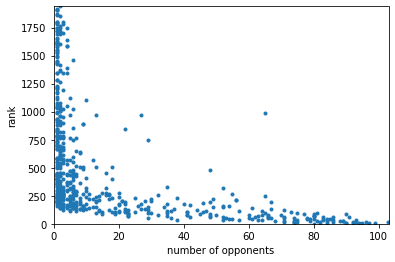

In [14]:
# 5.Pitanje
# Kako su rangirani na ATP listi teniseri koji su se susretali sa najvećim brojem drugih tenisera?
nodes = [node for (node, val) in G.degree()]
degrees = [val for (node, val) in G.degree()]

result = pd.DataFrame({'name' : nodes, 'degree' : degrees})
result = result.merge(ratingsMerged, on='name', how='inner').sort_values('degree', ascending=False)
print(result.head(10))
plot_correlation(result['degree'], result['rank'], 'number of opponents', 'rank')

In [15]:
# 6.Pitanje
# Iz kojih zemalja dolazi najveći broj aktivnih igrača u proteklom periodu?
data_grupisano = ratingsMerged[['name', 'nationality']].groupby('nationality')
data_agregirano = data_grupisano['name'].agg(np.size).sort_values(ascending=False)
print(data_agregirano.head(10))

nationality
USA    44
FRA    33
ITA    27
ESP    27
GER    26
ARG    19
AUS    17
RUS    15
CAN    10
GBR    10
Name: name, dtype: int64


In [16]:
# 7.Pitanje
# Iz kojih zemalja dolaze najuspešniji igrači u smislu osvojenih poena na ATP listi?
data_grupisano = ratingsMerged.head(100)[['name', 'nationality']].groupby('nationality')
data_agregirano = data_grupisano['name'].agg(np.size).sort_values(ascending=False)
print(data_agregirano.head(10))

nationality
FRA    11
ESP    10
USA     9
ITA     8
GER     5
ARG     5
SRB     5
AUS     4
CAN     4
GBR     3
Name: name, dtype: int64


Name: 
Type: Graph
Number of nodes: 581
Number of edges: 5330
Average degree:  18.3477
Max lokalni cc: 1.0
Prosečan cc: 0.18669394967031522
Lokalni stepeni klasterisanja koji nisu nula:
                     name        cc
157   Juan Pablo Varillas  0.027778
245        Roberto Quiroz  0.047619
301           Lucas Gomez  0.066667
248      Altug Celikbilek  0.066667
266         Benjamin Lock  0.066667
..                    ...       ...
269  Michail Pervolarakis  1.000000
289    Alexander Cozbinov  1.000000
279      Andrey Kuznetsov  1.000000
284         Gleb Sakharov  1.000000
307     Franco Roncadelli  1.000000

[308 rows x 2 columns]
                  name        cc
36      Novak Djokovic  0.390506
28        Rafael Nadal  0.400783
8        Dominic Thiem  0.354754
2      Daniil Medvedev  0.374785
48       Roger Federer  0.486857
1   Stefanos Tsitsipas  0.367759
4     Alexander Zverev  0.373572
12       Andrey Rublev  0.389263
11   Diego Schwartzman  0.345069
21   Matteo Berrettini  0.34

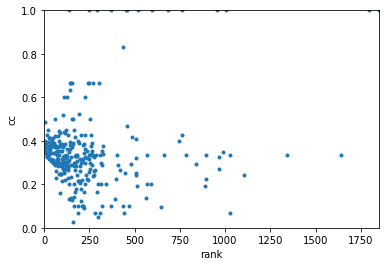

KendalltauResult(correlation=-0.14548166257720363, pvalue=0.00014897318417467825)


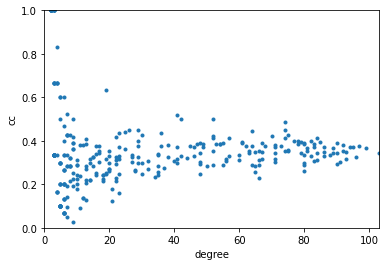

KendalltauResult(correlation=0.11161463215685327, pvalue=0.003974690422172194)
                    name  degree        cc
0        Karen Khachanov     103  0.344184
1     Stefanos Tsitsipas      99  0.367759
2        Daniil Medvedev      97  0.374785
3          Fabio Fognini      96  0.326096
4       Alexander Zverev      95  0.373572
5           Gael Monfils      94  0.371768
7  Roberto Bautista Agut      93  0.347125
6     Jan Lennard Struff      93  0.316269
9       Denis Shapovalov      92  0.380554
8          Dominic Thiem      92  0.354754
                    name  degree      id  rank  points hand  date_of_birth  \
0        Karen Khachanov     103  111575  20.0  2245.0    R     19960521.0   
1     Stefanos Tsitsipas      99  126774   6.0  5925.0    R     19980812.0   
2        Daniil Medvedev      97  106421   4.0  8470.0    R     19960211.0   
3          Fabio Fognini      96  104926  17.0  2400.0    R     19870524.0   
4       Alexander Zverev      95  100644   7.0  5525.0    

In [17]:
import scipy.stats as stats

print(nx.info(G))
id_igraca, clustering_coef = zip(*nx.clustering(G).items())

nenula = [(id_ig, cc)  for id_ig, cc in zip(id_igraca, clustering_coef) if cc > 0]

df = pd.DataFrame(nenula, columns = ["name", "cc"])
df.sort_values('cc', inplace = True)

max_lokalni_stepen_klasterisanja = max(clustering_coef)

prosecni_stepen_klasterisanja = nx.average_clustering(G)

print(f"Max lokalni cc: {max_lokalni_stepen_klasterisanja}")
print(f"Prosečan cc: {prosecni_stepen_klasterisanja}")
print("Lokalni stepeni klasterisanja koji nisu nula:")
print(df)

mergedPlayersAndClustering = result.merge(df, on='name', how='inner').sort_values('rank')
print(mergedPlayersAndClustering.head(10)[['name', 'cc']])
plot_correlation(mergedPlayersAndClustering['rank'], mergedPlayersAndClustering['cc'], 'rank', 'cc')
print(stats.kendalltau(mergedPlayersAndClustering['rank'], mergedPlayersAndClustering['cc']))
plot_correlation(mergedPlayersAndClustering['degree'], mergedPlayersAndClustering['cc'], 'degree', 'cc')
print(stats.kendalltau(mergedPlayersAndClustering['degree'], mergedPlayersAndClustering['cc']))
print(mergedPlayersAndClustering.sort_values('degree', ascending=False).head(10)[['name', 'degree','cc']])

In [19]:
import pickle

DC_dict = nx.degree_centrality(G)
CC_dict = nx.closeness_centrality(G)
BC_dict = nx.betweenness_centrality(G)
EVC_dict = nx.eigenvector_centrality(G)

df1 = pd.DataFrame.from_dict(DC_dict, orient='index', columns=['DC'])
df2 = pd.DataFrame.from_dict(CC_dict, orient='index', columns=['CC'])
df3 = pd.DataFrame.from_dict(BC_dict, orient='index', columns=['BC'])
df4 = pd.DataFrame.from_dict(EVC_dict, orient='index', columns=['EVC'])
df = pd.concat([df1, df2, df3, df4], axis=1)
df['name'] = df.index

ratingsMergedCentrality = ratingsMerged.merge(df, on='name', how='inner')
print(ratingsMergedCentrality)
with open("data/data_reduced_merged_centralities", 'wb') as file:
    pickle.dump(ratingsMergedCentrality, file)

         id                               name  rank   points hand  \
0    104925                     Novak Djokovic   1.0  12030.0    R   
1    104745                       Rafael Nadal   2.0   9850.0    L   
2    106233                      Dominic Thiem   3.0   9125.0    R   
3    106421                    Daniil Medvedev   4.0   8470.0    R   
4    103819                      Roger Federer   5.0   6630.0    R   
..      ...                                ...   ...      ...  ...   
576  200483                 Peter August Anker   NaN      NaN    U   
577  200401                  Amir Hossein Badi   NaN      NaN    U   
578  209867                  Daniil Ostapenkov   NaN      NaN  NaN   
579  209225  Martin Antonio Vergara Del Puerto   NaN      NaN    U   
580  207971                    Xavier Lawrence   NaN      NaN  NaN   

     date_of_birth nationality        DC        CC        BC           EVC  
0       19870522.0         SRB  0.137931  0.404719  0.006846  1.088015e-01  
1    

In [36]:
print(ratingsMergedCentrality.sort_values('BC', ascending=False).head(10)[['name', 'BC']])

                   name        BC
5    Stefanos Tsitsipas  0.068153
66         Pablo Cuevas  0.051584
217        Marius Copil  0.043192
496     Jeson Patrombon  0.034160
2         Dominic Thiem  0.029600
45         Albert Ramos  0.029416
70       Cameron Norrie  0.028368
364      Sanjar Fayziev  0.028271
28         Taylor Fritz  0.027244
57         Aljaz Bedene  0.023571


In [37]:
print(ratingsMergedCentrality[ratingsMerged['nationality'] == 'SRB'].drop(['nationality'], axis=1))

         id               name   rank   points hand  date_of_birth        DC  \
0    104925     Novak Djokovic    1.0  12030.0    R     19870522.0  0.137931   
25   105583      Dusan Lajovic   26.0   1785.0    R     19900630.0  0.153448   
30   105936   Filip Krajinovic   31.0   1628.0    R     19920227.0  0.129310   
43   200175  Miomir Kecmanovic   44.0   1308.0    R     19990831.0  0.094828   
56   111513        Laslo Djere   57.0   1058.0    R     19950602.0  0.113793   
139  110748   Nikola Milojevic  138.0    472.0    U     19950619.0  0.010345   
144  105905    Danilo Petrovic  142.0    458.0    R     19920124.0  0.006897   
204  104678     Viktor Troicki  201.0    323.0    R     19860210.0  0.051724   
262  104386   Janko Tipsarevic  263.0    208.0    R     19840622.0  0.029310   
266  106353       Pedja Krstin  267.0    204.0    R     19940903.0  0.005172   

           CC        BC       EVC  
0    0.404719  0.006846  0.108802  
25   0.419929  0.015747  0.116718  
30   0.3972

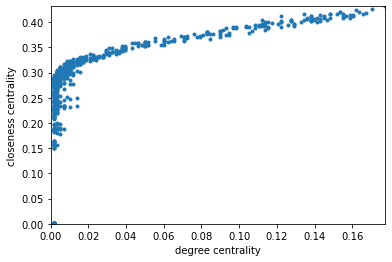

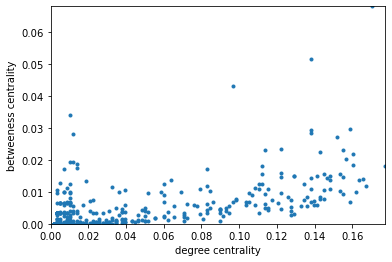

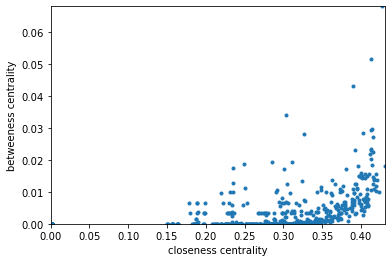

           DC        CC        BC       EVC
DC          1  0.823807  0.717621  0.819532
CC   0.823807         1  0.565376  0.956007
BC   0.717621  0.565376         1  0.546537
EVC  0.819532  0.956007  0.546537         1
               DC            CC            BC           EVC
DC   7.27304e-241  1.28116e-177  2.90026e-127  5.94403e-176
CC   1.28116e-177  3.17396e-282   3.35246e-86  2.39684e-258
BC   2.90026e-127   3.35246e-86  1.35411e-249   9.58478e-81
EVC  5.94403e-176  2.39684e-258   9.58478e-81  1.03532e-282


In [38]:
#Korelacije mera centralnosti cvorova
import scipy.stats as stats

plot_correlation(ratingsMergedCentrality['DC'], ratingsMergedCentrality['CC'], 'degree centrality', 'closeness centrality')
plot_correlation(ratingsMergedCentrality['DC'], ratingsMergedCentrality['BC'], 'degree centrality', 'betweeness centrality')
plot_correlation(ratingsMergedCentrality['CC'], ratingsMergedCentrality['BC'], 'closeness centrality', 'betweeness centrality')

labele = ['DC', 'CC', 'BC', 'EVC']
cross_correlation_matrix = pd.DataFrame(columns = ['DC', 'CC', 'BC', 'EVC'], index = ['DC', 'CC', 'BC', 'EVC'])
p_val_matrix = pd.DataFrame(columns = ['DC', 'CC', 'BC', 'EVC'], index = ['DC', 'CC', 'BC', 'EVC'])

for ind in labele:
    for col in labele:
        cross_correlation_matrix[ind][col], p_val_matrix[ind][col] =  stats.kendalltau(df[ind], df[col])
        
print(cross_correlation_matrix)
print(p_val_matrix)

In [39]:
# asortativnost na osnovu netežinskog stepena čvora
r1 = nx.degree_assortativity_coefficient(G)
print(f"Koeficijent asortativnosti na osnovu netežinskog stepena čvora: {r1}")

# asortativnost na osnovu težinskog stepena čvora
r2 = nx.degree_assortativity_coefficient(G, weight='weight')
print(f"Koeficijent asortativnosti na osnovu težinskog stepena čvora: {r2}")

# asortativnost na osnovu nacionalnosti
r3 = nx.attribute_assortativity_coefficient(G, 'nationality')
print(f"Koeficijent asortativnosti na osnovu nacionalnosti: {r3}")


# asortativnost na osnovu ranka
r5 = nx.numeric_assortativity_coefficient(G, 'rank')
print(f"Koeficijent asortativnosti na osnovu ranka: {r5}")


Koeficijent asortativnosti na osnovu netežinskog stepena čvora: 0.16919387110544537
Koeficijent asortativnosti na osnovu težinskog stepena čvora: 0.14652712553286887
Koeficijent asortativnosti na osnovu nacionalnosti: 0.009843043206048589
Koeficijent asortativnosti na osnovu ranka: 0.2528057176272261
